# 背景：使用所有词频向量，添加msg_cnt、server_model、fault_hour

## 导包、设置根目录

In [96]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import random
import pickle
import multiprocessing
import re
import pickle
from matplotlib import pyplot as plt

from collections import Counter
from itertools import chain
import datetime

# 更改工作目录为当前项目根目录
import sys
import os
os.chdir(os.path.dirname(os.path.dirname(sys.path[0])))
print(os.getcwd())

/Users/jincan02/Projects/Log-diagnosis


## 构建日志-标签表

In [37]:
# 读取sel日志数据
sel_log = pd.read_csv('./pre_contest/dataset/preliminary_sel_log_dataset.csv')
# 读取训练标签数据：有重复数据！
train_label1=pd.read_csv('./pre_contest/dataset/preliminary_train_label_dataset.csv')
train_label2=pd.read_csv('./pre_contest/dataset/preliminary_train_label_dataset_s.csv')
train_label=pd.concat([train_label1,train_label2],axis=0).drop_duplicates()

# sn+day仅有一条报错的日志筛选和
train_label['day']=train_label['fault_time'].apply(lambda x:x[0:10])
temp=train_label.groupby(['sn','day']).size()
use_temp=temp[temp.values==1]
sn_list=[use_temp.index[i][0] for i in range(len(use_temp))]
day_list=[use_temp.index[i][1] for i in range(len(use_temp))]
use_temp_df=pd.DataFrame({'sn':sn_list,'day':day_list})
use_train_label=pd.merge(train_label,use_temp_df,how='inner',on=['sn','day'])
sel_log['day']=sel_log['time'].apply(lambda x:x[0:10])
use_log_label_df=pd.merge(sel_log,use_train_label,how='inner',on=['sn','day'])
columns_order=['sn','day','time','msg','server_model','fault_time','label']
use_log_label_df=use_log_label_df[columns_order]

# 拼接日志
sn_list=[]
day_list=[]
server_model_list=[]
msg_log_list=[]
msg_cnt_list=[]
fault_hour_list=[]
label_list=[]
fault_time_list=[]
for msg_log_df in use_log_label_df.groupby(['sn','day']):
    msg_log_str=''
    for info in msg_log_df[1]['msg'].drop_duplicates():
        msg_log_str=msg_log_str+info.lower()+'.'
    label=msg_log_df[1].iloc[0]['label']
    sm=msg_log_df[1].iloc[0]['server_model']
    fault_time=msg_log_df[1].iloc[0]['fault_time']
    sn_list.append(msg_log_df[0][0])
    day_list.append(msg_log_df[0][1])
    server_model_list.append(sm)
    msg_log_list.append(msg_log_str)
    msg_cnt_list.append(len(msg_log_df[1]))
    label_list.append(label)
    fault_time_list.append(fault_time)
    fault_hour_list.append(datetime.datetime.strptime(fault_time, "%Y-%m-%d %H:%M:%S").hour)
msg_log_label_df=pd.DataFrame({'sn':sn_list,'day':day_list,'server_model':server_model_list,'msg_cnt':msg_cnt_list,'fault_hour':fault_hour_list,'msg_log':msg_log_list,'fault_time':fault_time_list,'label':label_list})
# msg_log_label_df.to_csv('./pre_contest/v1p4/msg_log_label_df.csv',sep=',',index=None)

In [40]:
msg_log_label_df

,sn,day,server_model,msg_cnt,fault_hour,msg_log,fault_time,label
0,SERVER_10001,2020-05-01,SM57,9,10,management subsys health system_health | sens...,2020-05-01 10:04:00,1
1,SERVER_10003,2020-03-28,SM57,117,9,memory cpu1d0_dimm_stat | correctable ecc | a...,2020-03-28 09:48:00,2
2,SERVER_10008,2020-02-25,SM53,5,16,processor cpu0_status | configuration error |...,2020-02-25 16:12:00,1
3,SERVER_10008,2020-03-11,SM53,4,18,processor cpu0_status | configuration error |...,2020-03-11 18:04:00,2
4,SERVER_10009,2020-05-08,SM53,4,16,drive slot hdd_l_14_status | drive fault | de...,2020-05-08 16:37:00,3
...,...,...,...,...,...,...,...,...
14416,SERVER_9991,2020-08-04,SM56,2,22,memory cpu0a0_dimm_stat | correctable ecc | a...,2020-08-04 22:49:00,2
14417,SERVER_9991,2020-10-07,SM56,1,18,memory cpu1a0_dimm_stat | correctable ecc | a...,2020-10-07 18:42:00,2
14418,SERVER_9993,2020-05-14,SM57,2,23,memory cpu1f0_dimm_stat | correctable ecc | a...,2020-05-14 23:50:00,2
14419,SERVER_9998,2020-05-29,SM57,2,11,memory cpu1e1_dimm_stat | correctable ecc | a...,2020-05-29 11:25:00,2


## 读取日志和标签数据

In [19]:
msg_log_label_df = pd.read_csv('./pre_contest/v1p4/msg_log_label_df.csv',sep=',')
msg_log_list=list(msg_log_label_df['msg_log'])
label_list=list(msg_log_label_df['label'])
msg_log_label_df

,sn,day,server_model,msg_cnt,msg_log,fault_time,label
0,SERVER_10001,2020-05-01,SM57,9,management subsys health system_health | sens...,2020-05-01 10:04:00,1
1,SERVER_10003,2020-03-28,SM57,117,memory cpu1d0_dimm_stat | correctable ecc | a...,2020-03-28 09:48:00,2
2,SERVER_10008,2020-02-25,SM53,5,processor cpu0_status | configuration error |...,2020-02-25 16:12:00,1
3,SERVER_10008,2020-03-11,SM53,4,processor cpu0_status | configuration error |...,2020-03-11 18:04:00,2
4,SERVER_10009,2020-05-08,SM53,4,drive slot hdd_l_14_status | drive fault | de...,2020-05-08 16:37:00,3
...,...,...,...,...,...,...,...
14416,SERVER_9991,2020-08-04,SM56,2,memory cpu0a0_dimm_stat | correctable ecc | a...,2020-08-04 22:49:00,2
14417,SERVER_9991,2020-10-07,SM56,1,memory cpu1a0_dimm_stat | correctable ecc | a...,2020-10-07 18:42:00,2
14418,SERVER_9993,2020-05-14,SM57,2,memory cpu1f0_dimm_stat | correctable ecc | a...,2020-05-14 23:50:00,2
14419,SERVER_9998,2020-05-29,SM57,2,memory cpu1e1_dimm_stat | correctable ecc | a...,2020-05-29 11:25:00,2


## 读取v1_baseline用的词和v1p1的新词

In [22]:
v1_word_list=list(pd.read_csv('pre_contest/v1p2/word_frequency_df.txt',sep='\t')['word'])
v1p1_word_list=list(pd.read_csv('pre_contest/v1p2/tags_incomplete.txt',sep='\t',names=['word'])['word'])
v1p2_word_list=list(set(v1_word_list+v1p1_word_list))

In [23]:
len(v1p2_word_list)

2087

## 训练词频向量

In [24]:
frequency_vector_list = []
tag=0
for word in v1p2_word_list:
    if tag%100==0:
        print(tag,datetime.datetime.now())
    pattern=re.compile(word)
    frequency_vector = [len(re.findall(pattern,log))  for log in msg_log_list]
    frequency_vector_list.append(frequency_vector)
    tag+=1

0 2022-03-26 18:47:18.122053
100 2022-03-26 18:47:19.692554
200 2022-03-26 18:47:21.305345
300 2022-03-26 18:47:22.810604
400 2022-03-26 18:47:24.350830
500 2022-03-26 18:47:25.823967
600 2022-03-26 18:47:27.343483
700 2022-03-26 18:47:28.979749
800 2022-03-26 18:47:30.552571
900 2022-03-26 18:47:32.139146
1000 2022-03-26 18:47:33.643426
1100 2022-03-26 18:47:35.196028
1200 2022-03-26 18:47:36.748236
1300 2022-03-26 18:47:38.285310
1400 2022-03-26 18:47:39.761231
1500 2022-03-26 18:47:41.397408
1600 2022-03-26 18:47:42.849158
1700 2022-03-26 18:47:44.346945
1800 2022-03-26 18:47:45.839452
1900 2022-03-26 18:47:47.350208
2000 2022-03-26 18:47:48.885455


In [55]:
frequency_vector_df=pd.DataFrame(frequency_vector_list)
frequency_vector_df=frequency_vector_df.T
frequency_vector_df.columns=v1p2_word_list
frequency_vector_df[['msg_cnt','fault_hour']]=msg_log_label_df[['msg_cnt','fault_hour']]
frequency_vector_df['server_model']=msg_log_label_df['server_model'].apply(lambda x:int(x[2:]))
frequency_vector_df['label']=label_list
frequency_vector_df['sn']=word_df['sn']
frequency_vector_df['day']=word_df['day']
feature=np.array(frequency_vector_df[v1p2_word_list+['server_model','msg_cnt','fault_hour']])

In [56]:
frequency_vector_df

,disk38_stat,system firmwares bios,hdd17,1,f67,unknown bmc fw info,0x81,hardware change detected,0203c0a80101,front2_3_status,...,cpu1e1_dimm_temp,transition to running processor,management,576,msg_cnt,fault_hour,server_model,label,sn,day
0,0,0,0,2,0,0,0,0,0,0,...,0,0,2,0,9,10,57,1,SERVER_10001,2020-05-01
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,117,9,57,2,SERVER_10003,2020-03-28
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,16,53,1,SERVER_10008,2020-02-25
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,18,53,2,SERVER_10008,2020-03-11
4,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,4,16,53,3,SERVER_10009,2020-05-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,22,56,2,SERVER_9991,2020-08-04
14417,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,18,56,2,SERVER_9991,2020-10-07
14418,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,23,57,2,SERVER_9993,2020-05-14
14419,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,2,11,57,2,SERVER_9998,2020-05-29


## 训练xgb模型

In [57]:
# xgb模型参数
xgb_params = {
    'booster':'gbtree',
    'objective':'multi:softmax',   # 多分类问题
    'num_class':4,  # 类别数，与multi softmax并用
    'gamma':0.1,    # 用于控制是否后剪枝的参数，越大越保守，一般0.1 0.2的样子
    'max_depth':6,  # 构建树的深度，越大越容易过拟合
    'lambda':2,  # 控制模型复杂度的权重值的L2 正则化项参数，参数越大，模型越不容易过拟合
    'subsample':1, # 随机采样训练样本
    'colsample_bytree':1,# 这个参数默认为1，是每个叶子里面h的和至少是多少
    # 对于正负样本不均衡时的0-1分类而言，假设h在0.01附近，min_child_weight为1
    #意味着叶子节点中最少需要包含100个样本。这个参数非常影响结果，
    # 控制叶子节点中二阶导的和的最小值，该参数值越小，越容易过拟合
    'silent':0,  # 设置成1 则没有运行信息输入，最好是设置成0
    'eta':0.3,  # 如同学习率
    'seed':1000,
    'nthread':16,  #CPU线程数
    #'eval_metric':'auc'
}

# 指标评估
def macro_f1(label,prediction)  -> float:

    """
    计算得分
    :param target_df: [sn,fault_time,label]
    :param submit_df: [sn,fault_time,label]
    :return:
    """

    weights =  [3  /  7,  2  /  7,  1  /  7,  1  /  7]
    macro_F1 =  0.
    for i in  range(len(weights)):
        TP =  np.sum((label==i) & (prediction==i))
        FP =  np.sum((label!= i) & (prediction == i))
        FN =  np.sum((label == i) & (prediction!= i))
        precision = TP /  (TP + FP)  if  (TP + FP)  >  0  else  0
        recall = TP /  (TP + FN)  if  (TP + FN)  >  0  else  0
        F1 =  2  * precision * recall /  (precision + recall)  if  (precision + recall)  >  0  else  0
        macro_F1 += weights[i]  * F1
        
        print('Task %d:\n Prcesion %.2f, Recall %.2f, F1 %.2f' % (i+1, precision, recall, F1))
        
    return macro_F1

In [58]:
random.seed(0)
label=np.array(label_list)
val_mask = [random.random() < 0.3 for _ in range(len(feature))]
train_mask = [not xx for xx in val_mask]
val_feature = feature[val_mask]
val_label = label[val_mask]
train_feature = feature[train_mask]
train_label = label[train_mask]
train_data=xgb.DMatrix(train_feature,label=train_label)
train_feature=xgb.DMatrix(train_feature)
val_feature=xgb.DMatrix(val_feature)

In [59]:
xgb_model=xgb.train(xgb_params,train_data,num_boost_round=500)

[19:02:52] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:02:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [60]:
train_pred=xgb_model.predict(train_feature)
val_pred=xgb_model.predict(val_feature)

In [61]:
macro_f1(train_label,train_pred)

Task 1:
 Prcesion 0.96, Recall 0.86, F1 0.91
Task 2:
 Prcesion 0.94, Recall 0.98, F1 0.96
Task 3:
 Prcesion 1.00, Recall 1.00, F1 1.00
Task 4:
 Prcesion 0.99, Recall 0.99, F1 0.99


0.9489161037940466

In [62]:
macro_f1(val_label,val_pred)
# 采用所有词的词频向量比采用词频+word2vec效果更佳

Task 1:
 Prcesion 0.48, Recall 0.36, F1 0.41
Task 2:
 Prcesion 0.73, Recall 0.75, F1 0.74
Task 3:
 Prcesion 0.94, Recall 0.97, F1 0.96
Task 4:
 Prcesion 0.90, Recall 0.92, F1 0.91


0.6552497836593232

# 用所有数据进行训练、保存模型、训练集

In [63]:
all_data=xgb.DMatrix(feature,label)
xgb_model_v1p4=xgb.train(xgb_params,all_data,num_boost_round=500)

[19:08:41] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:08:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [64]:
frequency_vector_df.head()

,disk38_stat,system firmwares bios,hdd17,1,f67,unknown bmc fw info,0x81,hardware change detected,0203c0a80101,front2_3_status,...,cpu1e1_dimm_temp,transition to running processor,management,576,msg_cnt,fault_hour,server_model,label,sn,day
0,0,0,0,2,0,0,0,0,0,0,...,0,0,2,0,9,10,57,1,SERVER_10001,2020-05-01
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,117,9,57,2,SERVER_10003,2020-03-28
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,16,53,1,SERVER_10008,2020-02-25
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,4,18,53,2,SERVER_10008,2020-03-11
4,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,4,16,53,3,SERVER_10009,2020-05-08


In [65]:
frequency_vector_df.to_csv('./pre_contest/v1p4/frequency_vector_df.csv',sep=',',index=None)
file = open('./pre_contest/v1p4/xgb_model_v1p4.model','wb')
pickle.dump(xgb_model_v1p4, file)

## 查看特征重要性、保存特征重要性前300的特征

In [66]:
total_gain_dict=xgb_model_v1p4.get_score(importance_type='total_gain')
total_gain_dict=dict(sorted(total_gain_dict.items(),key=lambda item:item[1],reverse=True))
feature_names=list(frequency_vector_df.columns)
feature_importance_top_300_dict={}
i=0
for key in total_gain_dict:
    if i<300:
        feature_name=feature_names[int(key[1:])]
        feature_importance_top_300_dict[feature_name]=total_gain_dict[key]
        i+=1
    else:
        break
feature_importance_top_300_dict

{'memory': 21123.45243284421,
 'or': 5881.042036111097,
 'cpu': 5716.3234210112,
 'processor': 3885.1959800870995,
 'server_model': 1773.9128654341987,
 'fault_hour': 1747.370655714596,
 'msg_cnt': 1478.6080896835028,
 'caterr': 1141.0103648597,
 'configuration': 985.2159661854,
 'e': 814.4563705800991,
 'c': 627.7859592230999,
 'ecc': 604.8906939258001,
 'deassert': 545.3393961459992,
 'uncorrectable ecc': 500.1016579803002,
 '0': 378.4115053882997,
 'ec': 377.3403901652001,
 'asserted': 315.8949280600997,
 'config': 313.3066467197001,
 'sta': 302.0275760806997,
 '0x3b': 283.9804268152001,
 'microcontroller/coprocessor': 259.81495140069995,
 'system': 258.9970990987,
 'status': 217.49152324740018,
 'device disabled': 201.243302593,
 'on': 187.69057669340012,
 'f': 187.43210163859987,
 'in': 185.119558555,
 'cpu0': 173.85201531440018,
 '1': 170.3315536165001,
 'fa': 168.8254460846999,
 'error': 165.62573643020002,
 'ierr': 158.6482763714999,
 'failure detected': 157.22600108700004,
 'u

In [67]:
feature_importance_top_300_df=frequency_vector_df[['sn','day','label']+list(feature_importance_top_300_dict.keys())]

In [68]:
# feature_importance_top_300_df.to_csv('./pre_contest/v1p4/feature_importance_top_300_df.csv',sep=',',index=None)

# 对初赛测试集进行预测

## 读取测试集数据、拼接数据

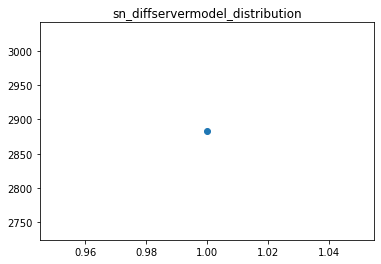

In [108]:
# 读取选手提交数据
submit_a=pd.read_csv('./pre_contest/dataset/preliminary_submit_dataset_a.csv')
submit_log=pd.read_csv('./pre_contest/dataset/preliminary_sel_log_dataset_a.csv')

# 所有sn的server_model均唯一
sel_log_sn_msg_df=pd.DataFrame({'server_model_cnt':submit_log.groupby('sn')['server_model'].nunique().values,'sn':submit_log.groupby('sn')['server_model'].nunique().index})
sel_log_sn_msg_distribution_series=sel_log_sn_msg_df.groupby('server_model_cnt').size()
plt.figure(3)
plt.title('sn_diffservermodel_distribution')
plt.plot(sel_log_sn_msg_distribution_series.index,sel_log_sn_msg_distribution_series.values,marker='o')

# 采用sn+day关联提交日志和报错时间
submit_a['day']=submit_a['fault_time'].apply(lambda x:x[0:10])
submit_log['day']=submit_log['time'].apply(lambda x:x[0:10])
preliminary_submit_dataset_a_temp=pd.merge(submit_a,submit_log,how='left',on=['sn','day'])
columns_order=['sn','day','time','msg','server_model','fault_time']
preliminary_submit_dataset_a_temp=preliminary_submit_dataset_a_temp[columns_order]

# 拼接日志
sn_list=[]
server_model_list=[]
msg_log_list=[]
msg_cnt_list=[]
fault_hour_list=[]
fault_time_list=[]
for msg_log_df in preliminary_submit_dataset_a_temp.groupby(['sn','fault_time']):
    msg_log_str=''
    for info in msg_log_df[1]['msg'].drop_duplicates():
        if info==info:
            msg_log_str=msg_log_str+info.lower()+'.'
    sn_list.append(msg_log_df[0][0])
    fault_time_list.append(msg_log_df[0][1])
    sm=msg_log_df[1].iloc[0]['server_model']
    if sm==sm:
        server_model_list.append(sm)
    else:
        sm=submit_log[submit_log['sn']==msg_log_df[0][0]]['server_model'].iloc[0]
        server_model_list.append(sm)
    msg_log_list.append(msg_log_str)
    msg_cnt_list.append(len(msg_log_df[1]))
    fault_hour_list.append(datetime.datetime.strptime(msg_log_df[0][1], "%Y-%m-%d %H:%M:%S").hour)
submit_msg_log_df=pd.DataFrame({'sn':sn_list,'fault_time':fault_time_list,'server_model':server_model_list,'msg_cnt':msg_cnt_list,'fault_hour':fault_hour_list,'msg_log':msg_log_list})


In [109]:
submit_msg_log_df

,sn,fault_time,server_model,msg_cnt,fault_hour,msg_log
0,000d33b21436,2020-09-02 16:42:54,SM40,2,16,system boot initiated bios_boot_up | initiate...
1,005c5a9218ba,2020-06-28 19:05:16,SM99,10,19,memory memory_status | correctable ecc | asse...
2,0079283bde6e,2020-04-26 21:32:44,SM14,1,21,power supply psu1_supply | failure detected |...
3,007bdf23b62f,2020-06-16 18:40:39,SM93,19,18,memory #0xe2 | correctable ecc | asserted. sy...
4,00a577a8e54f,2020-04-07 07:16:55,SM13,6,7,system boot initiated system restart | system...
...,...,...,...,...,...,...
3006,ffbf46b4af21,2019-12-28 20:10:01,SM35,3,20,memory cpu0c0_dimm_stat | correctable ecc | a...
3007,ffc229b6cd9a,2020-06-27 02:39:08,SM49,2,2,memory #0xe2 | correctable ecc | asserted.
3008,ffd44698a52b,2020-01-21 15:46:56,SM66,2,15,system acpi power state acpi_pwr_status | s4/...
3009,fff73a9e5bd5,2020-03-01 22:43:43,SM92,6,22,memory #0x87 | correctable ecc | asserted.


## 计算特征向量

In [113]:
# 统计词频向量
submit_frequency_vector_list = []
tag=0
for word in v1p2_word_list:
    if tag%100==0:
        print(tag,datetime.datetime.now())
    pattern=re.compile(word)
    frequency_vector = [len(re.findall(pattern,log))  for log in msg_log_list]
    submit_frequency_vector_list.append(frequency_vector)
    tag+=1                                                              

0 2022-03-27 18:08:41.880832
100 2022-03-27 18:08:42.203540
200 2022-03-27 18:08:42.488728
300 2022-03-27 18:08:42.811357
400 2022-03-27 18:08:43.105910
500 2022-03-27 18:08:43.386626
600 2022-03-27 18:08:43.673195
700 2022-03-27 18:08:43.972038
800 2022-03-27 18:08:44.259897
900 2022-03-27 18:08:44.549805
1000 2022-03-27 18:08:44.839941
1100 2022-03-27 18:08:45.146140
1200 2022-03-27 18:08:45.443219
1300 2022-03-27 18:08:45.742042
1400 2022-03-27 18:08:46.012978
1500 2022-03-27 18:08:46.307696
1600 2022-03-27 18:08:46.587595
1700 2022-03-27 18:08:46.878286
1800 2022-03-27 18:08:47.150380
1900 2022-03-27 18:08:47.443175
2000 2022-03-27 18:08:47.742825


In [123]:
submit_frequency_vector_df=pd.DataFrame(submit_frequency_vector_list)
submit_frequency_vector_df=submit_frequency_vector_df.T
submit_frequency_vector_df.columns=v1p2_word_list
submit_frequency_vector_df[['msg_cnt','fault_hour']]=submit_msg_log_df[['msg_cnt','fault_hour']]
submit_frequency_vector_df['server_model']=submit_msg_log_df['server_model'].apply(lambda x:int(x[2:]))
submit_frequency_vector_df[['sn','fault_time']]=submit_msg_log_df[['sn','fault_time']]
feature=np.array(submit_frequency_vector_df[v1p2_word_list+['server_model','msg_cnt','fault_hour']])  
# submit_frequency_vector_df.to_csv('./pre_contest/v1p4/submit_frequency_vector_df.csv',sep=',',index=None)

In [127]:
submit_frequency_vector_df

,disk38_stat,system firmwares bios,hdd17,1,f67,unknown bmc fw info,0x81,hardware change detected,0203c0a80101,front2_3_status,...,thermal,cpu1e1_dimm_temp,transition to running processor,management,576,msg_cnt,fault_hour,server_model,sn,fault_time
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,16,40,000d33b21436,2020-09-02 16:42:54
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10,19,99,005c5a9218ba,2020-06-28 19:05:16
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,21,14,0079283bde6e,2020-04-26 21:32:44
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,19,18,93,007bdf23b62f,2020-06-16 18:40:39
4,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,6,7,13,00a577a8e54f,2020-04-07 07:16:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,20,35,ffbf46b4af21,2019-12-28 20:10:01
3007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,2,49,ffc229b6cd9a,2020-06-27 02:39:08
3008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,15,66,ffd44698a52b,2020-01-21 15:46:56
3009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6,22,92,fff73a9e5bd5,2020-03-01 22:43:43


## 对测试集进行预测，保存特征和预测结果

In [119]:
submit_a

,sn,fault_time,day
0,000d33b21436,2020-09-02 16:42:54,2020-09-02
1,005c5a9218ba,2020-06-28 19:05:16,2020-06-28
2,0079283bde6e,2020-04-26 21:32:44,2020-04-26
3,007bdf23b62f,2020-06-16 18:40:39,2020-06-16
4,00a577a8e54f,2020-04-07 07:16:55,2020-04-07
...,...,...,...
3006,ffbf46b4af21,2019-12-28 20:10:01,2019-12-28
3007,ffc229b6cd9a,2020-06-27 02:39:08,2020-06-27
3008,ffd44698a52b,2020-01-21 15:46:56,2020-01-21
3009,fff73a9e5bd5,2020-03-01 22:43:43,2020-03-01


In [128]:
test_feature=xgb.DMatrix(feature)
submit_frequency_vector_df['prediction']=xgb_model_v1p4.predict(test_feature)
preliminary_submit_dataset_a=submit_frequency_vector_df[['sn','fault_time','prediction']]
preliminary_submit_dataset_a['label']=preliminary_submit_dataset_a['prediction'].apply(lambda x : int(x))
preliminary_submit_dataset_a=preliminary_submit_dataset_a[['sn','fault_time','label']]
# preliminary_submit_dataset_a.to_csv('pre_contest/v1p4/preliminary_submit_dataset_a_v1p4.csv',sep=',',index=None)

/var/folders/bh/sv71wm991pb8sm02bw8rmrfc0000gp/T/ipykernel_42552/3325616318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preliminary_submit_dataset_a['label']=preliminary_submit_dataset_a['prediction'].apply(lambda x : int(x))
